### Import Libraries

In [115]:
import numpy as np 
import pandas as pd

import time
from tqdm import tqdm, trange

import torch
from torch.optim import AdamW
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

from transformers import BertTokenizer, BertConfig
from transformers import BertForTokenClassification, AdamW
from transformers import get_linear_schedule_with_warmup

from sklearn.model_selection import train_test_split
from keras_preprocessing.sequence import pad_sequences
from seqeval.metrics import f1_score, accuracy_score

import plotly.graph_objects as go

import matplotlib.pyplot as plt
%matplotlib inline

torch.__version__

'1.10.0+cu102'

In [65]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.device_count())
print(device)

1
cuda


### Import Data

In [11]:
Paths = {
    'Data': './../../Data/',
    'Chia_w_scope': './../../Data/chia_with_scope/',
    'Chia_wo_scope': './../../Data/chia_without_scope/',
}

In [12]:
df = pd.read_csv(Paths['Data'] + 'Chia_w_scope_data.csv')
df = df.drop(columns=df.columns[0], axis=1)
df

,File,Criteria,Text,Group_Entities,Relations,Tokens,Entities
0,NCT01497639_inc,inc,"['ages of 7 and 75 years\n', 'marked disabilit...","[('T1', 0, 4, 'Person', 'ages'), ('T2', 8, 22,...","[('R1', 'Has_value', 'T1 T2'), ('*', 'OR', 'T6...","[['ages', 'of', '7', 'and', '75', 'years'], ['...","([['Person', 'O', 'B-Value', 'I-Value', 'I-Val..."
1,NCT01497639_exc,exc,"['previous brain surgery;\n', 'cognitive impai...","[('T1', 0, 8, 'Temporal', 'previous'), ('T2', ...","[('R1', 'Has_temporal', 'T2 T1'), ('R2', 'Has_...","[['previous', 'brain', 'surgery'], ['cognitive...","([['Temporal', 'B-Procedure', 'I-Procedure'], ..."
2,NCT02609698_inc,inc,"['Patients aged 19 or older\n', 'Patients who ...","[('T1', 9, 13, 'Person', 'aged'), ('T2', 14, 2...","[('R1', 'Has_value', 'T1 T2')]","[['Patients', 'aged', '19', 'or', 'older'], ['...","([['O', 'Person', 'B-Value', 'I-Value', 'I-Val..."
3,NCT02609698_exc,exc,['Patients with any contraindications or hyper...,"[('T1', 18, 35, 'Condition', 'contraindication...","[('*', 'OR', 'T1 T2'), ('*', 'OR', 'T6 T7'), (...","[['Patients', 'with', 'any', 'contraindication...","([['O', 'O', 'O', 'Condition', 'O', 'Condition..."
4,NCT01228279_inc,inc,"['Adult (age 18 years and older)\n', 'Patients...","[('T1', 0, 5, 'Person', 'Adult'), ('T2', 7, 10...","[('R1', 'Has_value', 'T2 T3'), ('R4', 'Has_qua...","[['Adult', 'age', '18', 'years', 'and', 'older...","([['Person', 'Person', 'B-Value', 'I-Value', '..."
...,...,...,...,...,...,...,...
1945,NCT00894712_exc,exc,"['Visible skin pathology, excessive freckles, ...","[('T1', 8, 22, 'Condition', 'skin pathology'),...","[('R1', 'Has_qualifier', 'T2 T3'), ('*', 'OR',...","[['Visible', 'skin', 'pathology', 'excessive',...","([['O', 'B-Condition', 'I-Condition', 'Qualifi..."
1946,NCT02361892_inc,inc,"['submucosal,\n', 'intramural or subserosal le...","[('T1', 0, 10, 'Condition', 'submucosal'), ('T...",[],"[['submucosal'], ['intramural', 'or', 'subsero...","([['Condition'], ['B-Condition', 'O', 'B-Condi..."
1947,NCT02361892_exc,exc,"['endometrial hyperplasia with atypia,\n', 'es...","[('T1', 0, 23, 'Condition', 'endometrial hyper...",[],"[['endometrial', 'hyperplasia', 'with', 'atypi...","([['B-Condition', 'I-Condition', 'O', 'Conditi..."
1948,NCT02375295_inc,inc,"['Male or Female.\n', 'No age restriction.\n',...","[('T1', 0, 4, 'Person', 'Male'), ('T2', 8, 14,...","[('*', 'OR', 'T1 T2'), ('R1', 'Has_qualifier',...","[['Male', 'or', 'Female'], ['No', 'age', 'rest...","([['Person', 'O', 'Person'], ['O', 'O', 'O'], ..."


In [14]:
df['Text'] = df['Text'].apply(eval)
df['Group_Entities'] = df['Group_Entities'].apply(eval)
df['Relations'] = df['Relations'].apply(eval)
df['Tokens'] = df['Tokens'].apply(eval)
df['Entities'] = df['Entities'].apply(eval)

### Preparing Data

In [15]:
entity_types = ['Condition', 'Drug', 'Procedure', 'Measurement', 'Observation', 'Person', 'Device', \
    'Value', 'Temporal', 'Qualifier', 'Negation']

entity_types

['Condition',
 'Drug',
 'Procedure',
 'Measurement',
 'Observation',
 'Person',
 'Device',
 'Value',
 'Temporal',
 'Qualifier',
 'Negation']

In [53]:
globalTags = []
globalTokens = []
prefixes = ['B-', 'I-']

for i, f in df.iterrows():
    entities_in_file = f['Entities']
    tokens_in_file = f['Tokens']
#     print(f['File'])
#     print(entities_in_file[0])
#     print(tokens_in_file)
#     break
    for ent in entities_in_file[0]:
        entity_arr = []
        for e in ent:
            if (any(e.startswith(x) for x in prefixes)) or (e=='O'): entity_arr.append(e)
            else: 
                new_e = 'B-'+ e
                entity_arr.append(new_e)
                
        globalTags.append(entity_arr)
    for t in tokens_in_file:
        globalTokens.append(t)
    assert len(globalTokens[-1]) == len(globalTags[-1])

assert len(globalTokens) == len(globalTags)

In [66]:
globalTags[:2]

[['B-Person', 'O', 'B-Value', 'I-Value', 'I-Value', 'I-Value'],
 ['O',
  'B-Condition',
  'O',
  'O',
  'B-Qualifier',
  'B-Qualifier',
  'O',
  'B-Qualifier',
  'B-Condition',
  'O',
  'B-Qualifier',
  'B-Procedure',
  'I-Procedure']]

In [56]:
ner_df = pd.DataFrame()
ner_df['Tags'] = pd.Series(globalTags)
ner_df['Sentence'] = pd.Series(globalTokens)
ner_df.head()

,Tags,Sentence
0,"[B-Person, O, B-Value, I-Value, I-Value, I-Value]","[ages, of, 7, and, 75, years]"
1,"[O, B-Condition, O, O, B-Qualifier, B-Qualifie...","[marked, disability, owing, to, primary, gener..."
2,"[B-Measurement, I-Measurement, O, B-Value, I-V...","[disease, duration, of, at, least, 5, years]"
3,"[B-Temporal, B-Procedure, I-Procedure]","[previous, brain, surgery]"
4,"[B-Condition, I-Condition, B-Value, I-Value, I...","[cognitive, impairment, <, 120, points, on, th..."


In [71]:
ner_df.head(60)

,Tags,Sentence
0,"[B-Person, O, B-Value, I-Value, I-Value, I-Value]","[ages, of, 7, and, 75, years]"
1,"[O, B-Condition, O, O, B-Qualifier, B-Qualifie...","[marked, disability, owing, to, primary, gener..."
2,"[B-Measurement, I-Measurement, O, B-Value, I-V...","[disease, duration, of, at, least, 5, years]"
3,"[B-Temporal, B-Procedure, I-Procedure]","[previous, brain, surgery]"
4,"[B-Condition, I-Condition, B-Value, I-Value, I...","[cognitive, impairment, <, 120, points, on, th..."
5,"[B-Qualifier, I-Qualifier, I-Qualifier, B-Cond...","[moderate, to, severe, depression, >, 25, poin..."
6,"[O, B-Condition, I-Condition, O, O, O, B-Proce...","[marked, brain, atrophy, as, detected, by, mag..."
7,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[other, medical, or, psychiatric, coexisting, ..."
8,"[O, B-Person, B-Value, I-Value, I-Value]","[Patients, aged, 19, or, older]"
9,"[O, O, O, O, O, O, O, O, O, O, O, O, O]","[Patients, who, have, submitted, a, written, c..."


### Basic EDA

In [58]:
entity_count = {}
for i, f in ner_df.iterrows():
    tags = f['Tags']
    for t in tags:
        try:
            entity_count[t] += 1
        except:
            entity_count[t] = 1
entity_count

{'B-Person': 1571,
 'O': 76594,
 'B-Value': 3648,
 'I-Value': 7568,
 'B-Condition': 11340,
 'B-Qualifier': 3970,
 'B-Procedure': 3293,
 'I-Procedure': 3331,
 'B-Measurement': 3055,
 'I-Measurement': 4294,
 'B-Temporal': 2921,
 'I-Condition': 10413,
 'I-Qualifier': 3155,
 'I-Temporal': 7936,
 'B-Observation': 1702,
 'I-Observation': 2141,
 'B-Drug': 3505,
 'B-Device': 349,
 'I-Device': 431,
 'I-Drug': 2299,
 'B-Negation': 835,
 'I-Negation': 236,
 'I-Person': 154}

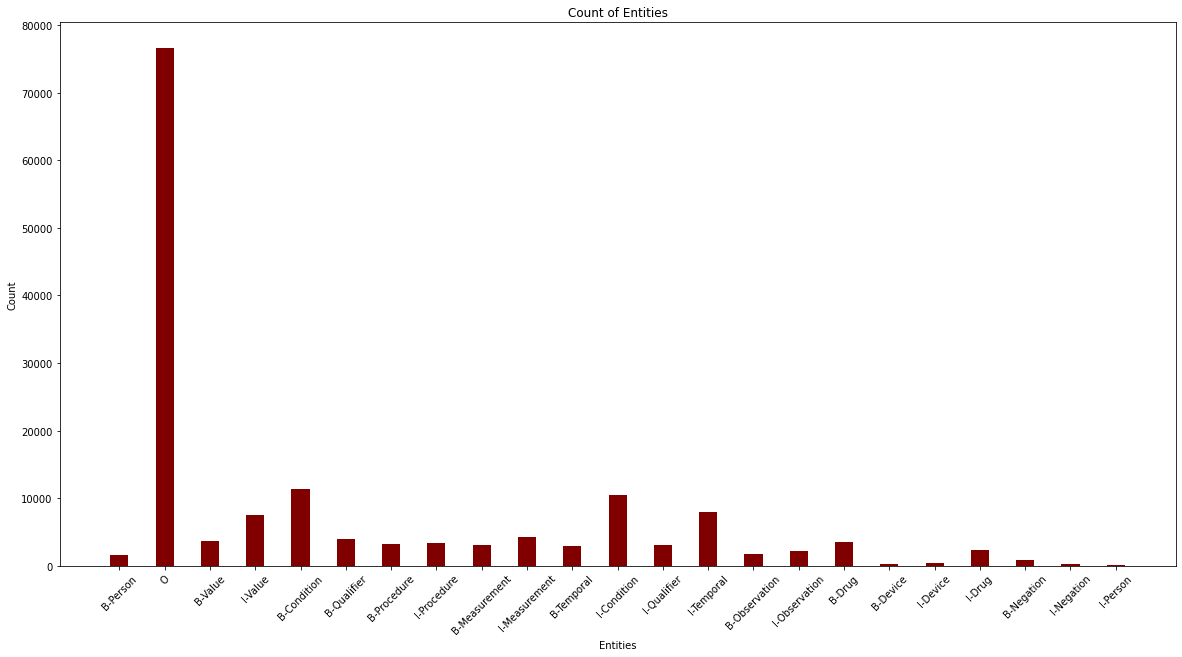

In [59]:
entity_names = list(entity_count.keys())
entity_values = list(entity_count.values())

fig = plt.figure(figsize = (20, 10))
 
plt.bar(entity_names, entity_values, color ='maroon', width = 0.4)

x = plt.gca().xaxis
for item in x.get_ticklabels():
    item.set_rotation(45)

plt.xlabel("Entities")
plt.ylabel("Count")
plt.title("Count of Entities")
plt.show()

In [60]:
entity_count_copy = entity_count
entity_count_copy.pop('O')

entity_names = list(entity_count_copy.keys())
entity_values = list(entity_count_copy.values())

entity_count_copy

{'B-Person': 1571,
 'B-Value': 3648,
 'I-Value': 7568,
 'B-Condition': 11340,
 'B-Qualifier': 3970,
 'B-Procedure': 3293,
 'I-Procedure': 3331,
 'B-Measurement': 3055,
 'I-Measurement': 4294,
 'B-Temporal': 2921,
 'I-Condition': 10413,
 'I-Qualifier': 3155,
 'I-Temporal': 7936,
 'B-Observation': 1702,
 'I-Observation': 2141,
 'B-Drug': 3505,
 'B-Device': 349,
 'I-Device': 431,
 'I-Drug': 2299,
 'B-Negation': 835,
 'I-Negation': 236,
 'I-Person': 154}

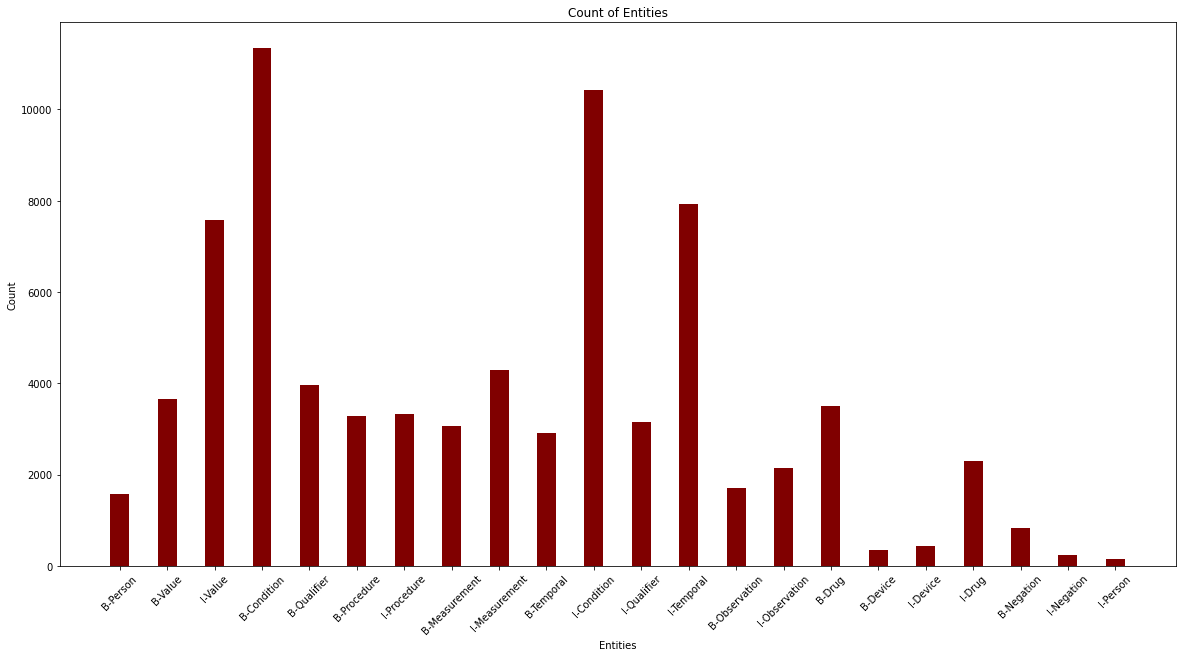

In [61]:
fig = plt.figure(figsize = (20, 10))
 
plt.bar(entity_names, entity_values, color ='maroon', width = 0.4)

x = plt.gca().xaxis
for item in x.get_ticklabels():
    item.set_rotation(45)

plt.xlabel("Entities")
plt.ylabel("Count")
plt.title("Count of Entities")
plt.show()

### Process Data for Model

In [99]:
entities = list(entity_count.keys())
entities.append('PAD')
entities.append('O')

tag_idx = {t: i for i, t in enumerate(entities)}
tag_idx

{'B-Person': 0,
 'B-Value': 1,
 'I-Value': 2,
 'B-Condition': 3,
 'B-Qualifier': 4,
 'B-Procedure': 5,
 'I-Procedure': 6,
 'B-Measurement': 7,
 'I-Measurement': 8,
 'B-Temporal': 9,
 'I-Condition': 10,
 'I-Qualifier': 11,
 'I-Temporal': 12,
 'B-Observation': 13,
 'I-Observation': 14,
 'B-Drug': 15,
 'B-Device': 16,
 'I-Device': 17,
 'I-Drug': 18,
 'B-Negation': 19,
 'I-Negation': 20,
 'I-Person': 21,
 'PAD': 22,
 'O': 23}

In [119]:
tag_values = list(tag_idx.keys())
tag_values

['B-Person',
 'B-Value',
 'I-Value',
 'B-Condition',
 'B-Qualifier',
 'B-Procedure',
 'I-Procedure',
 'B-Measurement',
 'I-Measurement',
 'B-Temporal',
 'I-Condition',
 'I-Qualifier',
 'I-Temporal',
 'B-Observation',
 'I-Observation',
 'B-Drug',
 'B-Device',
 'I-Device',
 'I-Drug',
 'B-Negation',
 'I-Negation',
 'I-Person',
 'PAD',
 'O']

In [86]:
TAGS = list(ner_df['Tags'])
TOKENS = list(ner_df['Sentence'])

print('First Sentence Length: {}'.format(len(TOKENS[0])))
print('Total Sentences: {}'.format(len(TOKENS)))

First Sentence Length: 6
Total Sentences: 12556


In [96]:
print(TOKENS[0], TAGS[0])

['ages', 'of', '7', 'and', '75', 'years'] ['B-Person', 'O', 'B-Value', 'I-Value', 'I-Value', 'I-Value']


In [88]:
listOfLengths = [len(item) for item in TOKENS]
listOfLengths.sort(reverse=True)
listOfLengths[:5]

[334, 300, 208, 207, 155]

In [92]:
def plot_bar_with_outliers(series, name, end):
    start = int(series.min())
    size = 10

    # Making a histogram
    largest_value = series.max()
    if largest_value > end:
        hist = np.histogram(series, bins=list(range(start, end+size, size)) + [largest_value])
    else:
        hist = np.histogram(series, bins=list(range(start, end+size, size)) + [end+size])

    # Adding labels to the chart
    labels = []
    for i, j in zip(hist[1][0::1], hist[1][1::1]):
        if j <= end:
            labels.append('{} - {}'.format(i, j))
        else:
            labels.append('> {}'.format(i))

    # Plotting the graph
    data = [go.Bar(x=labels,
                   y=hist[0])]

    layout = go.Layout(
        title=name
    )
    fig = go.Figure(data=data, layout=layout)
    fig.show()


plot_bar_with_outliers(pd.Series(listOfLengths), 'Length of Sentences', end=80)

### Bert

In [93]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case = False)

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [121]:
HYPER_PARAMETERS = {
    "MAX_LEN" : 80, # Max Length of the sentence
    "BATCH_SIZE" : 16,

    "EPOCHS" : 3,
    "MAX_GRAD_NORM" : 1.0,

    "LEARNING_RATE" : 3e-3,
    "EPSILON" : 1e-8
}

In [100]:
class DataProcessing:
    def __init__(self, sentences, text_labels, HYPER_PARAMETERS):
        self.sentences = sentences
        self.text_labels = text_labels
        self.HYPER_PARAMETERS = HYPER_PARAMETERS

        # List of tuples of tokenized sentences
        self.tokenized_texts_and_labels = [self.tokenize_preserve(sent,labs) for sent,labs in zip(self.sentences,self.text_labels)]
        # Seperates tokenized pairs into labels and tokens
        self.tokenized_text = [token_label_pair[0] for token_label_pair in self.tokenized_texts_and_labels]
        self.labels = [token_label_pair[1] for token_label_pair in self.tokenized_texts_and_labels] 

    def tokenize_preserve(self,sent,labs):
        tokenized_sentence = []
        labels = []

        for word, label in zip(sent,labs):
            tokenized_word = tokenizer.tokenize(word)
            n_subwords = len(tokenized_word)
            tokenized_sentence.extend(tokenized_word)
            labels.extend([label]*n_subwords)

        return tokenized_sentence, labels

    def getProcessedData(self,):
        input_ids = pad_sequences(
                              [tokenizer.convert_tokens_to_ids(txt) for txt in self.tokenized_text], # converts tokens to ids
                             maxlen= self.HYPER_PARAMETERS['MAX_LEN'], dtype='long',value=0.0,
                             truncating='post',padding='post')
        tags = pad_sequences(
                        [[tag_idx.get(l)for l in lab]for lab in self.labels], # Gets corresponding tag_id
                        maxlen= self.HYPER_PARAMETERS['MAX_LEN'], dtype='long', value=tag_idx['PAD'],
                        truncating='post',padding='post')

        attention_masks = [[float(i !=0.0) for i in ii]for ii in input_ids] # Float(True) = 1.0 for attention for only non-padded inputs

        self.printOutputs(input_ids, tags, attention_masks)

        return input_ids, tags, attention_masks

    def printOutputs(self,input_ids, tags, attention_masks):
        print('Inputs: {}'.format(input_ids[0]))
        print('Tags: {}'.format(tags[0]))
        print('Attention Mask: {}'.format(attention_masks[0]))
        print('Lengths Matching: {}, {}, {}'.format(len(input_ids[0]), len(tags[0]), len(attention_masks[0])))

In [101]:
dataProc = DataProcessing(TOKENS, TAGS, HYPER_PARAMETERS)
input_ids, tags, attention_masks = dataProc.getProcessedData()

Inputs: [6776 1104  128 1105 3453 1201    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0]
Tags: [ 0 23  1  2  2  2 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22
 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22
 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22
 22 22 22 22 22 22 22 22]
Attention Mask: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

In [102]:
print('Input Matrices Shape: {}'.format(input_ids.shape))

Input Matrices Shape: (12556, 80)


### Test Train Split

In [103]:
tr_input, val_input, tr_tag, val_tag = train_test_split(input_ids,tags,random_state=45,test_size=.15) # Get Train Test Split for Inputs and Tags
tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids, random_state=45, test_size=.15) # Get Split for NER
print('Input Train Size: {}, {}, {}:'.format(len(tr_masks),len(tr_input), len(tr_tag)))
print('Input Val Size: {}, {}, {}:'.format(len(val_masks),len(val_input), len(val_tag)))

Input Train Size: 10672, 10672, 10672:
Input Val Size: 1884, 1884, 1884:


In [104]:
# Converting to type tensor
tr_input = torch.tensor(tr_input)
val_input = torch.tensor(val_input)

tr_tag = torch.tensor(tr_tag)
val_tag = torch.tensor(val_tag)

tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)

### DataLoader

In [105]:
train_data = TensorDataset(tr_input, tr_masks, tr_tag)
train_data

In [106]:
train_data = TensorDataset(tr_input, tr_masks, tr_tag)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=HYPER_PARAMETERS['BATCH_SIZE'])

valid_data = TensorDataset(val_input, val_masks, val_tag)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=HYPER_PARAMETERS['BATCH_SIZE'])

In [107]:
model = BertForTokenClassification.from_pretrained( # Getting BERT's pretrained Token Classification model
'bert-base-cased',
num_labels=len(tag_idx),
output_attentions = False,
output_hidden_states = False)

model.cuda()

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

### Optimizer and LR Scheduler

In [113]:
FULL_FINETUNING = True
if FULL_FINETUNING: # Fine Tuning
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], # Setting Weight Decay Rate 0.01 if it isnt bias, gamma and beta
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], # If it is set to 0.0
         'weight_decay_rate': 0.0}
    ]
else: # Non Fine Tuning
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

In [116]:
# Optimizer
optimizer = AdamW(
    optimizer_grouped_parameters,
    lr= HYPER_PARAMETERS['LEARNING_RATE'],
    eps= HYPER_PARAMETERS['EPSILON']
)
# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * HYPER_PARAMETERS['EPOCHS']

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)
vars(train_dataloader)

{'dataset': <torch.utils.data.dataset.TensorDataset at 0x7f09a0719430>,
 'num_workers': 0,
 'prefetch_factor': 2,
 'pin_memory': False,
 'timeout': 0,
 'worker_init_fn': None,
 '_DataLoader__multiprocessing_context': None,
 '_dataset_kind': 0,
 'batch_size': 16,
 'drop_last': False,
 'sampler': <torch.utils.data.sampler.RandomSampler at 0x7f09a07193d0>,
 'batch_sampler': <torch.utils.data.sampler.BatchSampler at 0x7f09a07194c0>,
 'generator': None,
 'collate_fn': <function torch.utils.data._utils.collate.default_collate(batch)>,
 'persistent_workers': False,
 '_DataLoader__initialized': True,
 '_IterableDataset_len_called': None,
 '_iterator': None}

### Training and Validation

In [120]:
loss_values, validation_loss_values = [], []
E = 1
for _ in trange(HYPER_PARAMETERS['EPOCHS'], desc= "Epoch \n"):
    print('\n')
    print('Epoch #{}'.format(E))
  
    start = time.time()

    model.train()
    total_loss=0 # Reset at each Epoch
    
    ###################### TRAINING
    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch # Mantained the order for both train_data/val_data
        
        model.zero_grad() # Clearing previous gradients for each epoch
        
        outputs = model(b_input_ids, token_type_ids=None,
                       attention_mask=b_input_mask, labels=b_labels) # Forward pass
        
        loss = outputs[0]
        loss.backward() # Getting the loss and performing backward pass
        
        total_loss += loss.item() # Tracking loss
        
        # Preventing exploding grads
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=HYPER_PARAMETERS['MAX_GRAD_NORM'])
        
        optimizer.step() # Updates parameters
        scheduler.step() # Update learning_rate
        
    avg_train_loss = total_loss/len(train_dataloader) 
    print('Average Train Loss For Epoch {}: {}'.format(E, avg_train_loss))
    
    loss_values.append(avg_train_loss) # Storing loss values to plot learning curve
    
    ###################### VALIDATION
    model.eval()
    
    eval_loss = 0
    predictions, true_labels = [], []
    
    for batch in valid_dataloader:
        batch = tuple(t.to(device)for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        
        with torch.no_grad(): # No backprop
            outputs = model(b_input_ids, token_type_ids =None,
                           attention_mask=b_input_mask, labels=b_labels)
            
        logits = outputs[1].detach().cpu().numpy() # Getting Probabilities for Prediction Classes
        label_ids = b_labels.to('cpu').numpy() # Golden Labels
        
        loss = outputs[0]
        eval_loss += loss.item()

        predictions.extend([list(p) for p in np.argmax(logits, axis=2)]) # Taking Max among Prediction Classes
        true_labels.extend(label_ids)

    avg_eval_loss = eval_loss / len(valid_dataloader)
    print('Average Val Loss For Epoch {}: {}'.format(E, avg_eval_loss))

    validation_loss_values.append(avg_eval_loss)
    
    pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                for p_i, l_i, in zip(p,l)if tag_values[l_i] !='PAD']
    
    valid_tags = [tag_values[l_i]for l in true_labels
                 for l_i in l if tag_values[l_i] !='PAD']
    
    print('Validation Accuracy: {}%'.format(accuracy_score(pred_tags,valid_tags)*100))
    print('Validation F-1 Score:{}'.format(f1_score([pred_tags], [valid_tags])))

    stop = time.time()
    print('Epoch #{} Duration:{}'.format(E, stop-start))
    E+=1
    print('-'*20)
    time.sleep(3)

Epoch 
:   0%|                                                  | 0/3 [00:00<?, ?it/s]



Epoch #1
Average Train Loss For Epoch 1: 0.16465412939841423
Average Val Loss For Epoch 1: 0.17344203856536897
Validation Accuracy: 75.61560841006568%
Validation F-1 Score:0.6481081795357441
Epoch #1 Duration:65.24586606025696
--------------------


/home/umar.salman/G42/nlp2sqlEnv/lib/python3.8/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning:

PAD seems not to be NE tag.

Epoch 
:  33%|██████████████                            | 1/3 [01:08<02:16, 68.25s/it]



Epoch #2
Average Train Loss For Epoch 2: 0.12865304011387982
Average Val Loss For Epoch 2: 0.17527340832403152
Validation Accuracy: 76.26645871449567%
Validation F-1 Score:0.661654796447727
Epoch #2 Duration:66.43817377090454
--------------------


Epoch 
:  67%|████████████████████████████              | 2/3 [02:17<01:08, 68.95s/it]



Epoch #3
Average Train Loss For Epoch 3: 0.1157877110754666
Average Val Loss For Epoch 3: 0.17527340832403152
Validation Accuracy: 76.26645871449567%
Validation F-1 Score:0.661654796447727
Epoch #3 Duration:66.83220219612122
--------------------


Epoch 
Epoch |██████████████████████████████████████████| 3/3 [03:27<00:00, 69.36s/it]
: 100%|██████████████████████████████████████████| 3/3 [03:27<00:00, 69.18s/it]
